# **AlexNET**

IMPORT DATASET

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZ-LQXHjSztIrv5ayecz_nUBdHRni8ko4p_vCS1zypkhOw?download=1 -O CelebA_HQ_face_gender_dataset.zip
!unzip CelebA_HQ_face_gender_dataset.zip -d ./CelebA_HQ_face_gender_dataset

Impor library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

Mounted at /content/drive


Pengambilan dataset Serta jumlah dataset

In [ ]:
# Transforms untuk preprocessing data training dengan augmentasi tambahan
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),               # Memperbesar ukuran gambar agar cropping tidak kehilangan banyak detail
    transforms.RandomResizedCrop(224),           # Crop gambar secara acak ke ukuran 224x224
    transforms.RandomHorizontalFlip(),           # Augmentasi dengan flip horizontal acak
    transforms.RandomRotation(10),               # Rotasi acak hingga 10 derajat
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ubah kecerahan, kontras, dll.
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi menggunakan mean dan std dari ImageNet
                     [0.229, 0.224, 0.225])
])

# Transforms untuk preprocessing data testing (tanpa augmentasi)
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi dengan mean dan std dari dataset ImageNet
                     [0.229, 0.224, 0.225])
])

# Path ke dataset CelebA_HQ_face_gender_dataset
data_dir = './CelebA_HQ_face_gender_dataset'

# Buat dataset training dengan augmentasi dan preprocessing yang telah didefinisikan di atas
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)

# Buat dataset testing dengan preprocessing tanpa augmentasi
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

# Buat DataLoader untuk training dengan batch_size 16, shuffle=True, dan 2 worker
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Buat DataLoader untuk testing dengan batch_size 16, shuffle=True, dan 2 worker
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

# Ukuran dataset training
print('Train dataset size:', len(train_dataset))

# Ukuran dataset testing
print('Test dataset size:', len(test_dataset))

# Mendapatkan nama kelas dari dataset
class_names = train_dataset.classes
print('Class names:', class_names)



Train dataset size: 23999
Test dataset size: 6001
Class names: ['female', 'male']


Menampilkan jumlah dataset Male Female


In [ ]:
import os

# Function to count images in each class folder (male/female)
def count_images_in_folder(dataset_path):
    male_path = os.path.join(dataset_path, 'male')
    female_path = os.path.join(dataset_path, 'female')

    # Count the number of files in each folder
    num_male = len(os.listdir(male_path))
    num_female = len(os.listdir(female_path))

    return num_male, num_female

# Specify the paths for training and testing datasets
train_dataset_path = 'CelebA_HQ_face_gender_dataset/train'
test_dataset_path = 'CelebA_HQ_face_gender_dataset/test'

# Count images in training and testing datasets
train_male, train_female = count_images_in_folder(train_dataset_path)
test_male, test_female = count_images_in_folder(test_dataset_path)

# Display the results
print(f"Training Data: Male: {train_male}, Female: {train_female}")
print(f"Testing Data: Male: {test_male}, Female: {test_female}")


Training Data: Male: 8845, Female: 15154
Testing Data: Male: 2212, Female: 3789


Menampilkan beberapa contoh dataset

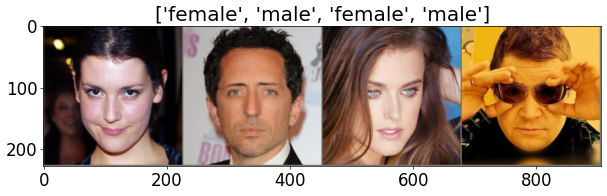

In [ ]:
# Mengatur ukuran dan resolusi dari gambar yang akan ditampilkan
plt.rcParams['figure.figsize'] = [12, 8]  # Ukuran figure (12 x 8 inci)
plt.rcParams['figure.dpi'] = 60           # DPI (dots per inch) untuk resolusi gambar
plt.rcParams.update({'font.size': 20})     # Mengatur ukuran font menjadi 20

# Fungsi untuk menampilkan gambar (imshow)
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))  # Mengubah tensor dari PyTorch ke numpy array dan menukar dimensi untuk ditampilkan
    # Membalik normalisasi pada gambar agar kembali ke nilai aslinya (undo normalization)
    mean = np.array([0.485, 0.456, 0.406])      # Mean dari normalisasi yang dipakai saat preprocessing
    std = np.array([0.229, 0.224, 0.225])       # Standar deviasi dari normalisasi
    input = std * input + mean                  # Kembalikan gambar ke rentang nilai aslinya
    input = np.clip(input, 0, 1)                # Potong nilai agar tetap berada di antara 0 dan 1 (untuk menyesuaikan batas piksel)
    # Menampilkan gambar menggunakan matplotlib
    plt.imshow(input)
    plt.title(title)                            # Beri judul pada gambar
    plt.show()                                  # Tampilkan gambar

# Mengambil satu batch dari data training
iterator = iter(train_dataloader)  # Membuat iterator dari train_dataloader

# Visualisasi satu batch dari gambar training
inputs, classes = next(iterator)   # Mengambil batch pertama dari iterator (gambar dan label kelas)
out = torchvision.utils.make_grid(inputs[:4])  # Membuat grid dari 4 gambar pertama dalam batch
imshow(out, title=[class_names[x] for x in classes[:4]])  # Menampilkan gambar dengan label kelas yang sesuai


Cek gambar yang duplikat

No duplicate images found.


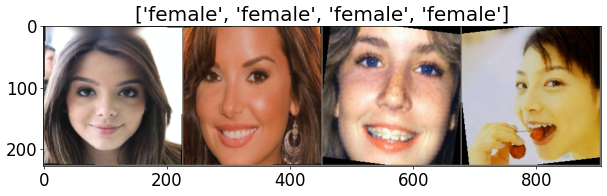

In [ ]:
import hashlib
from collections import defaultdict

# Fungsi untuk menghasilkan hash dari gambar numpy array
def generate_image_hash(image_array):
    # Mengubah numpy array menjadi bytes, lalu hash dengan SHA-256
    return hashlib.sha256(image_array.tobytes()).hexdigest()

# Fungsi untuk menampilkan gambar (imshow)
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))  # Mengubah tensor dari PyTorch ke numpy array dan menukar dimensi untuk ditampilkan
    # Membalik normalisasi pada gambar agar kembali ke nilai aslinya (undo normalization)
    mean = np.array([0.485, 0.456, 0.406])      # Mean dari normalisasi yang dipakai saat preprocessing
    std = np.array([0.229, 0.224, 0.225])       # Standar deviasi dari normalisasi
    input = std * input + mean                  # Kembalikan gambar ke rentang nilai aslinya
    input = np.clip(input, 0, 1)                # Potong nilai agar tetap berada di antara 0 dan 1 (untuk menyesuaikan batas piksel)
    # Menampilkan gambar menggunakan matplotlib
    plt.imshow(input)
    plt.title(title)                            # Beri judul pada gambar
    plt.show()                                  # Tampilkan gambar

# Fungsi untuk mengecek duplikasi gambar dalam satu batch
def check_for_duplicates(images):
    hashes = defaultdict(list)  # Dictionary untuk menyimpan hash gambar
    duplicate_indices = []      # List untuk menyimpan indeks gambar duplikat

    # Looping untuk setiap gambar dalam batch
    for idx, img in enumerate(images):
        img_np = img.numpy().transpose((1, 2, 0))  # Convert ke numpy array
        img_hash = generate_image_hash(img_np)     # Generate hash gambar
        if img_hash in hashes:
            duplicate_indices.append(idx)          # Simpan indeks gambar duplikat
        else:
            hashes[img_hash].append(idx)           # Simpan hash gambar baru

    return duplicate_indices

# Mengambil satu batch dari data training
iterator = iter(train_dataloader)  # Membuat iterator dari train_dataloader

# Visualisasi satu batch dari gambar training
inputs, classes = next(iterator)   # Mengambil batch pertama dari iterator (gambar dan label kelas)

# Mengecek apakah ada duplikasi dalam batch
duplicate_indices = check_for_duplicates(inputs)
if duplicate_indices:
    print(f'Duplicate images found at indices: {duplicate_indices}')
    # Jika ada duplikat, bisa melakukan tindakan tambahan di sini, misal membuang duplikat
else:
    print('No duplicate images found.')

# Jika tidak ada duplikat, lanjutkan visualisasi
out = torchvision.utils.make_grid(inputs[:4])  # Membuat grid dari 4 gambar pertama dalam batch
imshow(out, title=[class_names[x] for x in classes[:4]])  # Menampilkan gambar dengan label kelas yang sesuai


Inisiasi Model

In [ ]:
# Menginisialisasi model AlexNet dengan pre-trained weights
model = models.alexnet(pretrained=True)

# Mengambil jumlah fitur input dari layer terakhir (classifier[6] adalah fully connected layer terakhir)
num_features = model.classifier[6].in_features

# Mengganti layer fully connected terakhir dengan layer baru untuk klasifikasi biner
# nn.Linear(num_features, 2) artinya kita mengganti layer dengan jumlah output 2 (klasifikasi biner)
model.classifier[6] = nn.Linear(num_features, 2)  # binary classification (num_of_class == 2)

# Memindahkan model ke device (GPU/CPU tergantung setting)
model = model.to(device)

# Mendefinisikan loss function. CrossEntropyLoss digunakan untuk klasifikasi multi-kelas, termasuk biner
criterion = nn.CrossEntropyLoss()

# Menggunakan optimizer SGD (Stochastic Gradient Descent) dengan learning rate 0.001 dan momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 147MB/s]


Training Model

[Train #0] Loss: 0.1172 Acc: 95.3373% Time: 430.8690s
[Test #0] Loss: 0.0899 Acc: 96.8839% Time: 502.8523s
[Train #1] Loss: 0.1128 Acc: 95.3998% Time: 933.2569s
[Test #1] Loss: 0.0940 Acc: 96.3340% Time: 1001.9517s
[Train #2] Loss: 0.1087 Acc: 95.5956% Time: 1429.6540s
[Test #2] Loss: 0.0780 Acc: 97.1005% Time: 1498.9996s
[Train #3] Loss: 0.1055 Acc: 95.6540% Time: 1929.7228s
[Test #3] Loss: 0.0666 Acc: 97.3671% Time: 1999.4600s
[Train #4] Loss: 0.1033 Acc: 95.8790% Time: 2427.9649s
[Test #4] Loss: 0.0579 Acc: 97.6004% Time: 2497.9470s


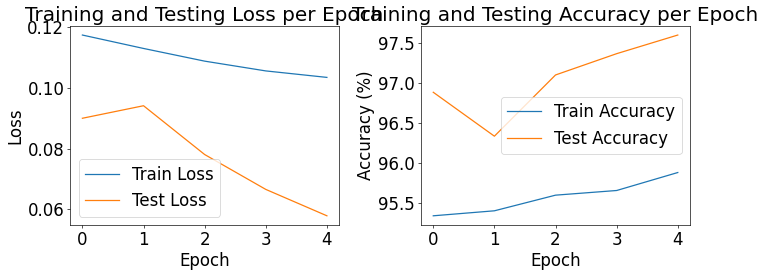

In [16]:
import time
import matplotlib.pyplot as plt

# Jumlah epoch untuk proses training
num_epochs = 5

# Menyimpan waktu mulai training
start_time = time.time()

# List untuk menyimpan nilai loss dan akurasi setiap epoch
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Loop untuk setiap epoch
for epoch in range(num_epochs):
    """ Training Phase """
    model.train()  # Mengatur model ke mode training

    running_loss = 0.  # Menyimpan akumulasi loss dalam satu epoch
    running_corrects = 0  # Menyimpan jumlah prediksi yang benar dalam satu epoch

    # Loop untuk setiap batch dari train_dataloader
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU (jika ada)
        labels = labels.to(device)  # Memindahkan label ke GPU (jika ada)

        # Forward pass
        optimizer.zero_grad()  # Reset gradient agar tidak terakumulasi
        outputs = model(inputs)  # Mendapatkan output dari model
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi dengan nilai terbesar
        loss = criterion(outputs, labels)  # Menghitung loss

        # Backpropagation dan update parameter
        loss.backward()  # Hitung gradien melalui backpropagation
        optimizer.step()  # Update weight model menggunakan gradien

        # Mengakumulasi total loss dan correct predictions
        running_loss += loss.item() * inputs.size(0)  # Total loss dikali jumlah sample di batch ini
        running_corrects += torch.sum(preds == labels.data)  # Jumlah prediksi yang benar

    # Hitung rata-rata loss dan akurasi untuk satu epoch
    epoch_loss = running_loss / len(train_dataset)  # Rata-rata loss
    epoch_acc = running_corrects / len(train_dataset) * 100.  # Akurasi dalam persentase

    # Simpan loss dan akurasi training
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())  # Ubah ke item() untuk mendapatkan nilai float

    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()  # Mengatur model ke mode evaluasi

    with torch.no_grad():  # Non-aktifkan gradient computation selama evaluasi
        running_loss = 0.
        running_corrects = 0

        # Loop untuk setiap batch dari test_dataloader
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU
            labels = labels.to(device)  # Memindahkan label ke GPU

            # Forward pass tanpa backpropagation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi
            loss = criterion(outputs, labels)  # Hitung loss

            # Akumulasi total loss dan correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Hitung rata-rata loss dan akurasi untuk test set
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.

        # Simpan loss dan akurasi testing
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc.item())  # Ubah ke item() untuk mendapatkan nilai float

        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

# Plot grafik loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss per Epoch')
plt.legend()

# Plot grafik akurasi
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


Simpan Model

In [ ]:
save_path = 'face_gender_classification_transfer_learning_with_Alexnet.pth'  # Tentukan path dan nama file untuk menyimpan model
torch.save(model.state_dict(), save_path)  # Simpan state_dict model (berisi bobot dan bias) ke file .pth


In [ ]:
image_path = 'sri.jpeg'

In [ ]:
!ls /content/drive/MyDrive/face_gender_classification_transfer_learning_with_Alexnet.pth

/content/drive/MyDrive/face_gender_classification_transfer_learning_with_Alexnet.pth


Test model dengan menggunakan gambar inputan

<ipython-input-7-0803252f6365>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Muat bobot


Predicted: Female


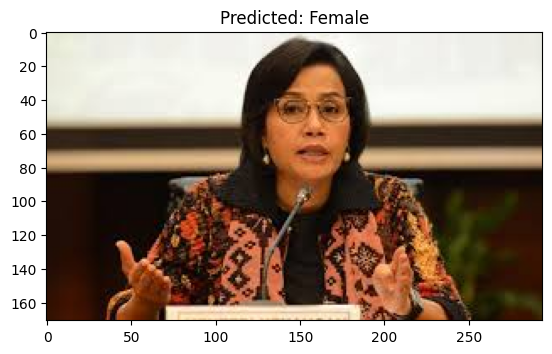

In [ ]:
model_path = '/content/drive/MyDrive/face_gender_classification_transfer_learning_with_Alexnet.pth'

# Preprocessing gambar, sesuai dengan transformasi yang dipakai saat training
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar ke 224x224
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi (mean & std dari ImageNet)
                         [0.229, 0.224, 0.225])
])

# Muat gambar dari file
image = Image.open(image_path)

# Preprocess gambar
image_tensor = preprocess(image).unsqueeze(0)  # Menambahkan batch dimension di depan

# Pindahkan gambar ke device (GPU/CPU)
image_tensor = image_tensor.to(device)

# Memuat model yang telah dilatih
model = models.alexnet(pretrained=True)  # Inisialisasi model AlexNet
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # Klasifikasi biner (2 kelas)
model.load_state_dict(torch.load(model_path))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi

with torch.no_grad():
    outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
    _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']  # Misalnya untuk klasifikasi gender
print('Predicted:', class_names[preds.item()])

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']
predicted_label = class_names[preds.item()]

# Plot gambar dan hasil prediksi
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.show()



Confusion Matrix

<ipython-input-8-81133859bfcf>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Muat bobot


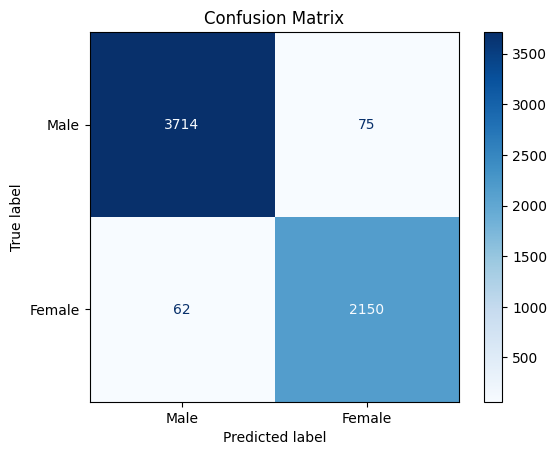

In [ ]:
model_path = '/content/drive/MyDrive/face_gender_classification_transfer_learning_with_Alexnet.pth'
# Memuat model yang telah dilatih
model = models.alexnet(pretrained=True)  # Inisialisasi model AlexNet
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # Klasifikasi biner (2 kelas)
model.load_state_dict(torch.load(model_path))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi

all_preds = []
all_labels = []

# Path to the test dataset
test_female_folder = 'CelebA_HQ_face_gender_dataset/test/female'
test_male_folder = 'CelebA_HQ_face_gender_dataset/test/male'

# Load images and their corresponding labels
image_paths = []
true_labels = []

# Load female images
for image_name in os.listdir(test_female_folder):
    image_paths.append(os.path.join(test_female_folder, image_name))
    true_labels.append(0)  # 0 for Female

# Load male images
for image_name in os.listdir(test_male_folder):
    image_paths.append(os.path.join(test_male_folder, image_name))
    true_labels.append(1)  # 1 for Male

# Process each image
for image_path, true_label in zip(image_paths, true_labels):
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

    # Simpan hasil prediksi dan label asli
    all_preds.append(preds.item())
    all_labels.append(true_label)

# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])  # Sesuaikan dengan label asli
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



Pengambilan Gambar Dari Webcam

<IPython.core.display.Javascript object>

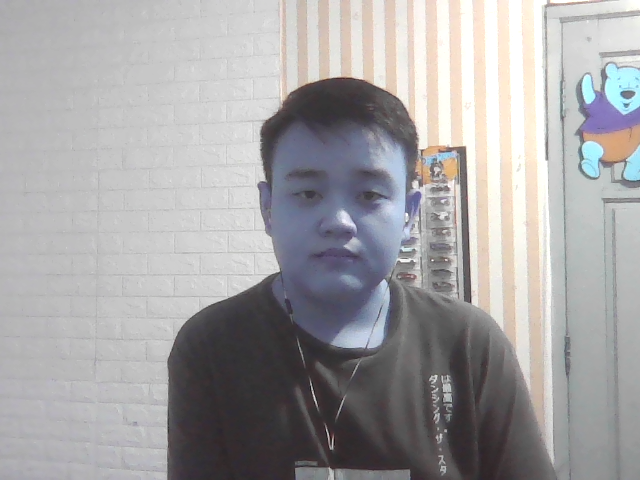

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import PIL
import io
from google.colab.patches import cv2_imshow  # Pastikan ini diimpor

# Menampilkan video stream
def js_code():
    return """
    async function captureImage() {
        const video = document.createElement('video');
        const canvas = document.createElement('canvas');
        const context = canvas.getContext('2d');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(video);
        video.srcObject = stream;
        await new Promise((resolve) => {
          video.onloadedmetadata = () => {
            resolve(video.play());
          };
        });
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        context.drawImage(video, 0, 0, canvas.width, canvas.height);
        stream.getTracks().forEach(track => track.stop());
        video.remove();
        return canvas.toDataURL('image/png');
    }
    captureImage();
    """

def capture_image():
    display(Javascript(js_code()))
    data = eval_js('captureImage()')
    binary = b64decode(data.split(',')[1])
    image = np.array(PIL.Image.open(io.BytesIO(binary)))
    return image

# Mengambil gambar dari webcam
image = capture_image()

# Menampilkan gambar menggunakan cv2_imshow
cv2_imshow(image)


Proses Hasil Foto Webcam

<ipython-input-40-2b68fcf748c9>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Memuat bobot model


Prediksi: male


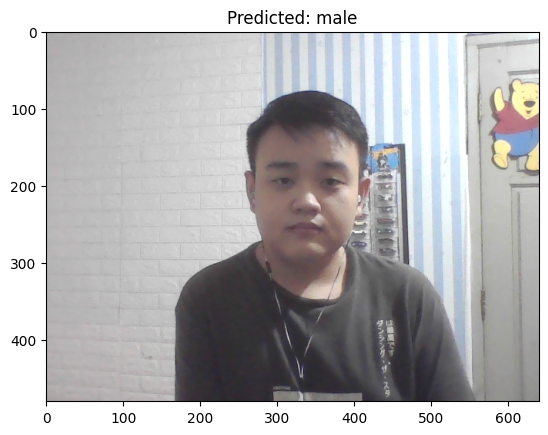

In [ ]:

# Load model dengan PyTorch
model_path = '/content/drive/MyDrive/face_gender_classification_transfer_learning_with_Alexnet.pth'

# Misalkan Anda menggunakan AlexNet sebagai model transfer learning
model = models.alexnet(pretrained=False)
num_ftrs = model.classifier[6].in_features  # Mendapatkan ukuran fitur terakhir dari AlexNet
model.classifier[6] = nn.Linear(num_ftrs, 2)  # Sesuaikan output dengan klasifikasi gender (2 kelas: male/female)
model.load_state_dict(torch.load(model_path))  # Memuat bobot model
model.eval()  # Set model ke mode evaluasi

# Preprocessing gambar sesuai dengan yang digunakan saat pelatihan
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize gambar sesuai dengan ukuran input model
    transforms.ToTensor(),  # Mengubah gambar menjadi tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisasi (mean & std untuk ImageNet)
])

# Mengambil gambar dari webcam, dan konversi dari BGR ke RGB
image_resized = cv2.resize(image, (224, 224))  # Mengubah ukuran gambar
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)  # Ubah dari BGR ke RGB

# Preprocessing gambar
image_tensor = preprocess(image_rgb).unsqueeze(0)  # Tambahkan batch dimension

# Menggunakan gambar sebagai input untuk model
with torch.no_grad():  # Nonaktifkan kalkulasi gradien selama inferensi
    output = model(image_tensor)
    prediction = torch.argmax(output, dim=1)  # Mendapatkan prediksi kelas

# Menampilkan hasil prediksi
classes = ['female', 'male']  # Sesuaikan dengan urutan kelas pada model Anda
print(f'Prediksi: {classes[prediction]}')

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']
predicted_label = classes[prediction]

# Plot gambar dan hasil prediksi
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.show()